In [38]:
import os, os.path, re
import numpy as np
from collections import Counter
from sys import getsizeof
import time
from sklearn.preprocessing import normalize, scale, MinMaxScaler
from sklearn.cluster import *

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [40]:
dataset = pd.read_csv('/home/kuluandrej/cafedra2015-2016/Experiments on Machine Learning/Datasets/WIKI-AAPL.csv')
time_series = dataset['Open']
backup_time_series = time_series

In [8]:
files_path = 'ts_processing/'
ts_labels = ['chest_volume', 'heart_rate', 'oxygen_concentration']
ts_labels = sorted(ts_labels)

number_ts_pieces = len(os.listdir(files_path)) / len(ts_labels)
# if the number is not divided 
if abs(number_ts_pieces - round(number_ts_pieces)) > 0:
    print('ERROR: invalid number of files in ', files_path)
else:
    number_ts_pieces = int(number_ts_pieces)    

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]

file_names = sorted(os.listdir(files_path), key=natural_keys)

In [9]:
# set of labels of ts to classify
# labels = chest_volume, heart_rate, oxygen_concentration
labels = ['chest_volume', 'heart_rate', 'oxygen_concentration']
# locations of the ts
root_path = '/MVR_py/ts_processing/'
# extension of files containing data about ts
extension = '.txt'
# folder for output files
where_to_store_models = 'collected_models2/'
# specifies number of segments for ts to be split on
number_of_segments = 340

def retrieve_ts(label):
    
    dataset_filename     = '/data/data_to_fit.txt'
    init_models_filename = '/data/init_models.txt'
    
    
    
    DATA_LOCAL_PATH = root_path
    script_dir = os.path.dirname('__file__')
    parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
    DATA_FULL_PATH = parent_dir + DATA_LOCAL_PATH + label + extension
    # retrieve the data to fit from the specified file
    data_to_fit = np.loadtxt(DATA_FULL_PATH, delimiter = ',')
    data_to_fit = np.vstack((data_to_fit, np.linspace(0,1, len(data_to_fit)))).T
    return data_to_fit



In [10]:
def get_segment_of_ts(data, index_of_segment, length_of_segments):
    return data[index_of_segment * length_of_segments : (index_of_segment + 1) * length_of_segments, :]

ts_label = oxygen_concentration ; index_of_segment = 0


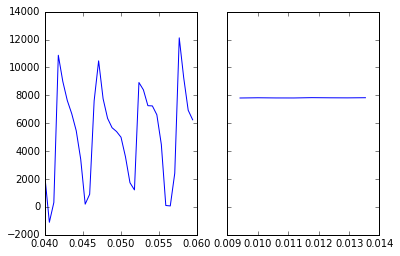

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

index_of_segment = 0
data = retrieve_ts(ts_labels[0])
segment = get_segment_of_ts(data, 2, 34)
X = segment[:,1]
y = segment[:,0]

ax1.plot(X,y)

index_of_segment = 0

print("ts_label =", ts_labels[2], "; index_of_segment =", index_of_segment)

data = retrieve_ts(ts_labels[2])
segment = get_segment_of_ts(data, 2, int(data.shape[0] / 200))
X = segment[:,1]
y = segment[:,0]
ax2.plot(X,y)
plt.show()



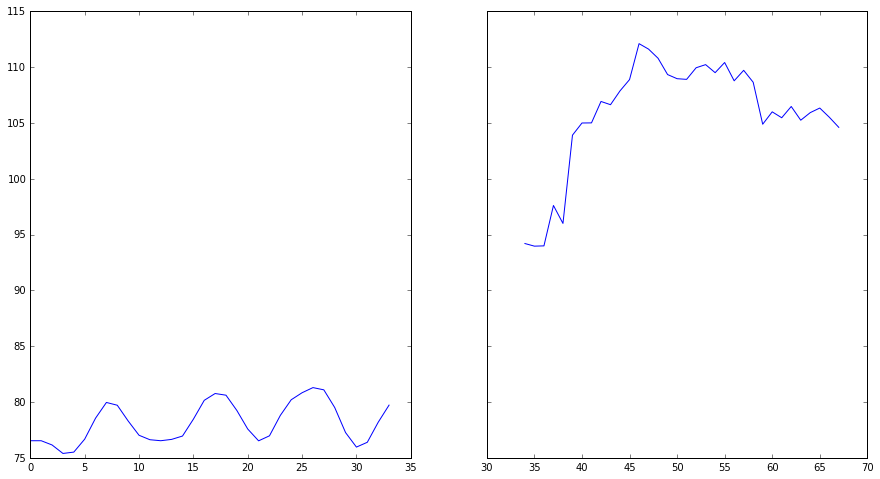

In [41]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/heart_rate.txt', 'r')
data = np.loadtxt(file) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(15)
num_seg = 0
num_rows = 34
ax1.plot(data[num_seg * num_rows : num_seg * num_rows + num_rows,])
num_seg = 1
ax2.plot(data[num_seg * num_rows : num_seg * num_rows + num_rows,])


In [43]:
np.savetxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/open_apple.txt', backup_time_series[0:1700], fmt = '%.4f')

ts_label = chest_volume ; index_of_segment = 0


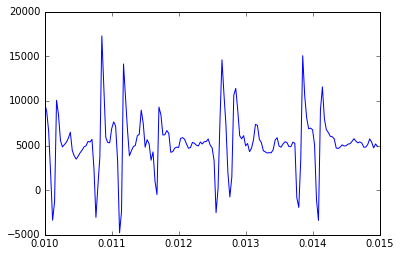

In [51]:
index_of_segment = 0
print("ts_label =", ts_labels[0], "; index_of_segment =", index_of_segment)
data = retrieve_ts(ts_labels[0])
segment = get_segment_of_ts(data, 2, int(data.shape[0] / 200))
X = segment[:,1]
y = segment[:,0]
plt.plot(X,y)
plt.show()

In [5]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]

files_path = 'populations/first_segments2/'
file_names = sorted(os.listdir(files_path), key=natural_keys)
files_path_dest = 'populations/first_segments3/'

if not os.path.isdir(files_path_dest):
    os.makedirs(files_path_dest)

    
for file in file_names:
    number_of_file = int(file[:-4].split('_')[-1])
    if number_of_file >= 51:
        os.rename(files_path + file, files_path_dest + file)

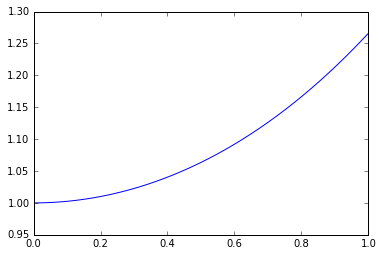

In [33]:
x = np.arange(0,1,.002)
y = np.i0(x)
plt.plot(x,y)

Script dealing with data removing from 'init_models'

In [35]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/init_models.txt', 'r')
lines = file.readlines()
file.close()
file = open('/home/kuluandrej/cafedra2015-2016/Experiments on Machine Learning/Datasets/WIKI-AAPL.csv', 'w')
required_rows = 5000
for i in range(required_rows):
    file.write(lines[i])
file.close()